In [17]:
# Install required packages (run this first)
!pip install numpy pandas matplotlib scikit-learn seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')   


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
print("Loading Australian weather data...")
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/_0eYOqji3unP1tDNKWZMjg/weatherAUS-2.csv"
df = pd.read_csv(url)

print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
df.head()

Loading Australian weather data...
Dataset shape: (145460, 23)

First few rows:


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [3]:
print("Data info:")
df.info()

print("\nMissing values count:")
df.isnull().sum()

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       895

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

In [4]:
# Drop rows with missing values
print(f"Original dataset size: {len(df)}")
df = df.dropna()
print(f"After removing missing values: {len(df)}")

# Rename columns for clarity
df = df.rename(columns={
    'RainToday': 'RainYesterday',
    'RainTomorrow': 'RainToday'
})

# Focus on Melbourne area
melbourne_locations = ['Melbourne', 'MelbourneAirport', 'Watsonia']
df = df[df.Location.isin(melbourne_locations)]
print(f"After filtering Melbourne area: {len(df)}")

Original dataset size: 145460
After removing missing values: 56420
After filtering Melbourne area: 7557


In [5]:
def date_to_season(date):
    """Convert date to season"""
    month = date.month
    if month in [12, 1, 2]:
        return 'Summer'
    elif month in [3, 4, 5]:
        return 'Autumn'
    elif month in [6, 7, 8]:
        return 'Winter'
    elif month in [9, 10, 11]:
        return 'Spring'

# Exercise 1: Create seasons
df['Date'] = pd.to_datetime(df['Date'])
df['Season'] = df['Date'].apply(date_to_season)
df = df.drop(columns=['Date'])

print("Season distribution:")
df['Season'].value_counts()

Season distribution:


Season
Autumn    1947
Winter    1918
Spring    1911
Summer    1781
Name: count, dtype: int64

In [8]:
# Exercise 2 & 3: Features and target
X = df.drop(columns='RainToday', axis=1)
y = df['RainToday']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Check class balance
target_counts = y.value_counts()
print("\nTarget distribution:")
print(target_counts)
print(f"Rain percentage: {target_counts['Yes']/len(y)*100:.1f}%")

Features shape: (7557, 22)
Target shape: (7557,)

Target distribution:
RainToday
No     5766
Yes    1791
Name: count, dtype: int64
Rain percentage: 23.7%


In [9]:
# Exercise 5: Split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Training set: {len(X_train)}, Test set: {len(X_test)}")
y_train.value_counts(normalize=True)

Training set: 6045, Test set: 1512


RainToday
No     0.762945
Yes    0.237055
Name: proportion, dtype: float64

In [10]:
# Exercise 6: Feature types
numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Numeric: {len(numeric_features)}")
print(f"Categorical: {len(categorical_features)}")

# Exercise 7: Transformers
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

Numeric: 16
Categorical: 6


In [11]:
# Exercise 8 & 9: Pipeline and GridSearch
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

print(f"Best params: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'classifier__max_depth': 20, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Best CV score: 0.8524


Test accuracy: 0.8446

Classification Report:
              precision    recall  f1-score   support

          No       0.86      0.95      0.90      1154
         Yes       0.75      0.51      0.61       358

    accuracy                           0.84      1512
   macro avg       0.81      0.73      0.76      1512
weighted avg       0.84      0.84      0.83      1512



<Figure size 800x600 with 0 Axes>

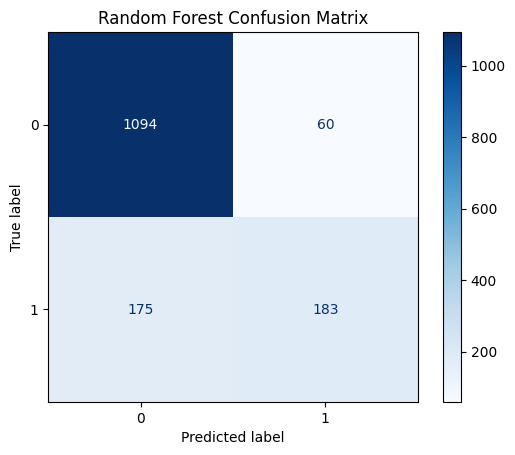

In [12]:
# Exercise 10-13: Evaluation
test_score = grid_search.score(X_test, y_test)
y_pred_rf = grid_search.predict(X_test)

print(f"Test accuracy: {test_score:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# Confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf)
disp.plot(cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.show()

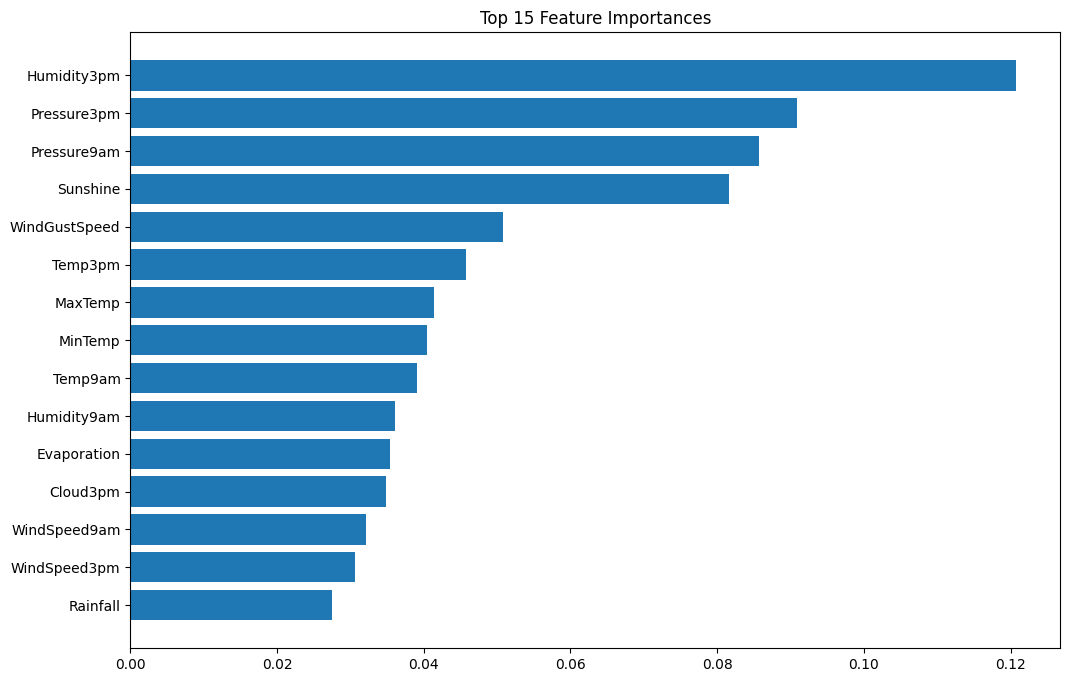

Top 10 features:
          Feature  Importance
9     Humidity3pm    0.120752
11    Pressure3pm    0.090827
10    Pressure9am    0.085730
4        Sunshine    0.081560
5   WindGustSpeed    0.050779
15        Temp3pm    0.045733
1         MaxTemp    0.041407
0         MinTemp    0.040418
14        Temp9am    0.039146
8     Humidity9am    0.036119


In [13]:
# Exercise 14: Feature importance
feature_importances = grid_search.best_estimator_['classifier'].feature_importances_

feature_names = numeric_features + list(
    grid_search.best_estimator_['preprocessor']
    .named_transformers_['cat'].named_steps['onehot']
    .get_feature_names_out(categorical_features)
)

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(12, 8))
top_15 = importance_df.head(15)
plt.barh(range(len(top_15)), top_15['Importance'])
plt.yticks(range(len(top_15)), top_15['Feature'])
plt.gca().invert_yaxis()
plt.title('Top 15 Feature Importances')
plt.show()

print("Top 10 features:")
print(importance_df.head(10))

In [14]:
# Exercise 15: Alternative model
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

param_grid_lr = {
    'classifier__solver': ['liblinear'],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__class_weight': [None, 'balanced']
}

grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=cv, scoring='accuracy')
grid_search_lr.fit(X_train, y_train)

test_score_lr = grid_search_lr.score(X_test, y_test)
y_pred_lr = grid_search_lr.predict(X_test)

print(f"Logistic Regression accuracy: {test_score_lr:.4f}")
print(f"Random Forest accuracy: {test_score:.4f}")

Logistic Regression accuracy: 0.8300
Random Forest accuracy: 0.8446


In [16]:
# Model comparison
print("FINAL MODEL COMPARISON")
print("="*30)
print(f"Random Forest Accuracy: {test_score:.4f} ({test_score*100:.1f}%)")
print(f"Logistic Regression Accuracy: {test_score_lr:.4f} ({test_score_lr*100:.1f}%)")

# True positive rates
tn_rf, fp_rf, fn_rf, tp_rf = confusion_matrix(y_test, y_pred_rf).ravel()
tn_lr, fp_lr, fn_lr, tp_lr = confusion_matrix(y_test, y_pred_lr).ravel()

tpr_rf = tp_rf / (tp_rf + fn_rf)
tpr_lr = tp_lr / (tp_lr + fn_lr)

print(f"Random Forest TPR: {tpr_rf:.4f}")
print(f"Logistic Regression TPR: {tpr_lr:.4f}")

print(f"\n Project Complete! Best accuracy: {max(test_score, test_score_lr)*100:.1f}%")

FINAL MODEL COMPARISON
Random Forest Accuracy: 0.8446 (84.5%)
Logistic Regression Accuracy: 0.8300 (83.0%)
Random Forest TPR: 0.5112
Logistic Regression TPR: 0.5140

 Project Complete! Best accuracy: 84.5%
